In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import glob
from datetime import datetime, timedelta

#assuming we are in Q1 directory , we go to the parent folder
# Path to the folder containing the CSV files
folder_path = os.path.join('..', 'new_data')  # Assuming you want to work with the sampled data

# Get all the CSV files from the folder
csv_files = glob.glob(folder_path + '/*.csv')


In [2]:
# Columns to analyze
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

# Create a dictionary to store the grouped data for each action
action_labels = [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 130, 140] #action labels
action_data_dict = {label: [] for label in action_labels} #dictionary initialization

In [3]:
# List to store data from all files
all_data = []

# Load each CSV file and group data by action (label)
for idx,csv_file in enumerate(csv_files):
    # Load the CSV file into a dataframe
    df = pd.read_csv(csv_file)

    # Add a new column 'file_id' containing the identifier
    df['file_id'] = idx + 1  # Adding 1 to start file IDs from 1
    
    # Append the DataFrame to the list
    all_data.append(df)
    
    # Group data by label and store in the dictionary
    grouped_data = df.groupby('label')
    for label, group in grouped_data:
        action_data_dict[label].append(group)

# Combine all data into a single DataFrame
combined_data = pd.concat(all_data)

Text(0.5, 1.0, 'Distribution of Activity Labels')

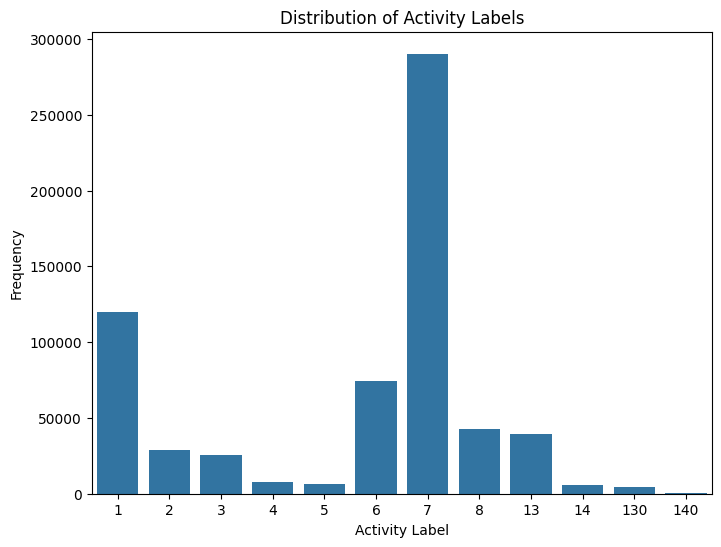

In [4]:
"""DISTRIBUTION OF ACTIVITY LABELS"""

# Calculate the frequency of each label
label_distribution = combined_data['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.xlabel('Activity Label')
plt.ylabel('Frequency')
plt.title('Distribution of Activity Labels')

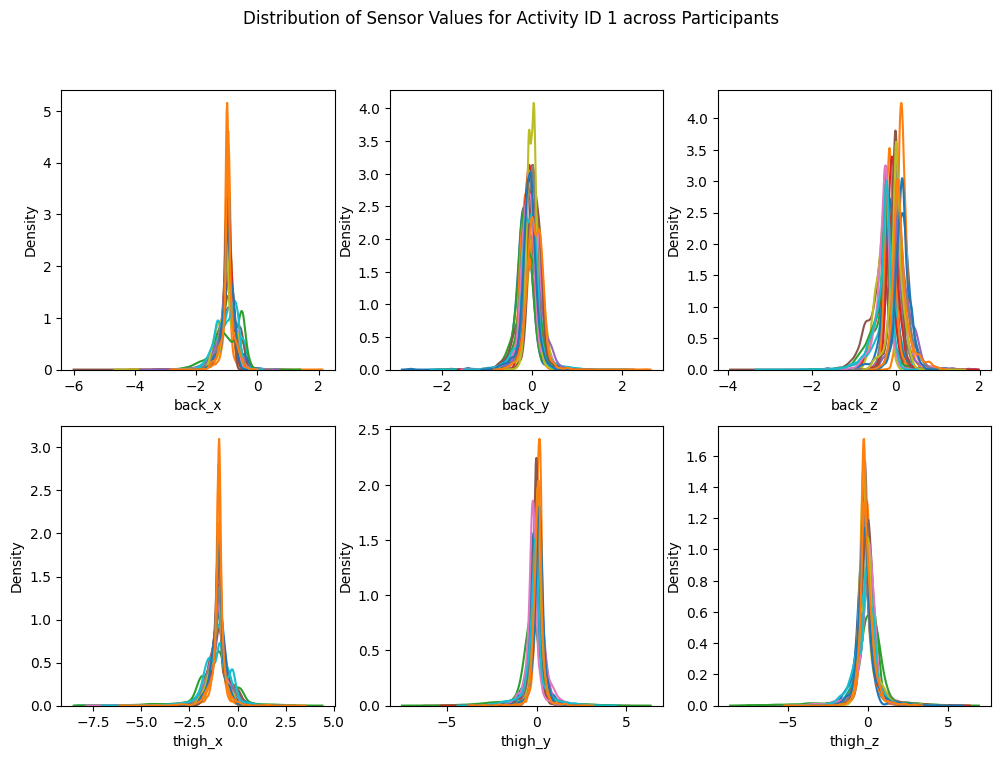

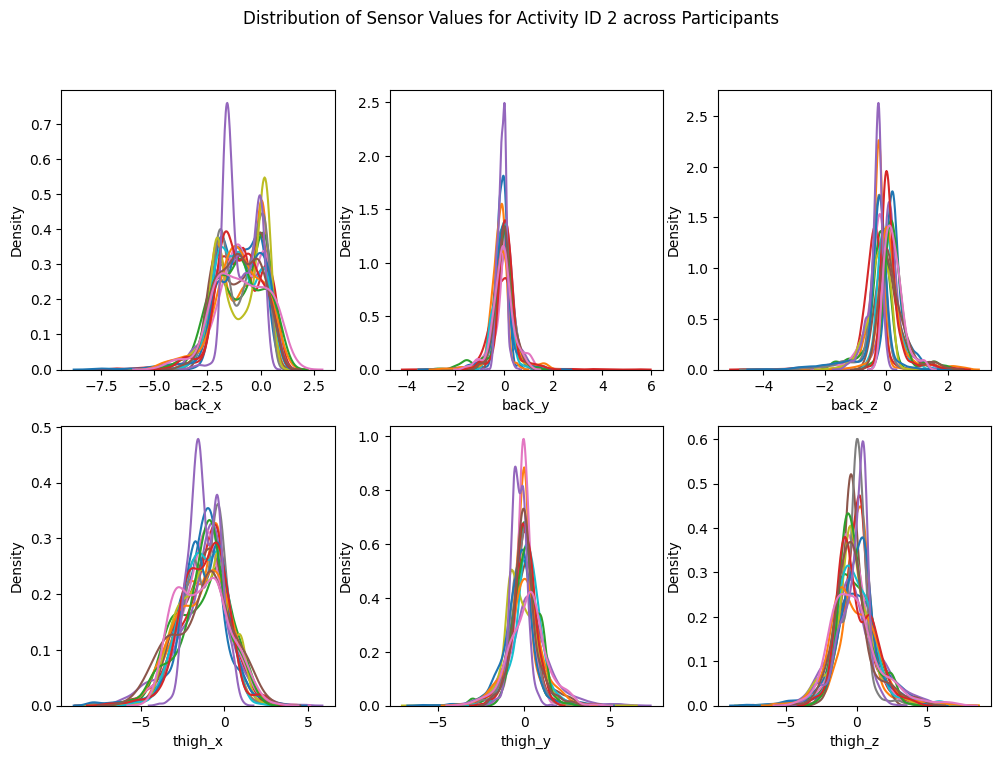

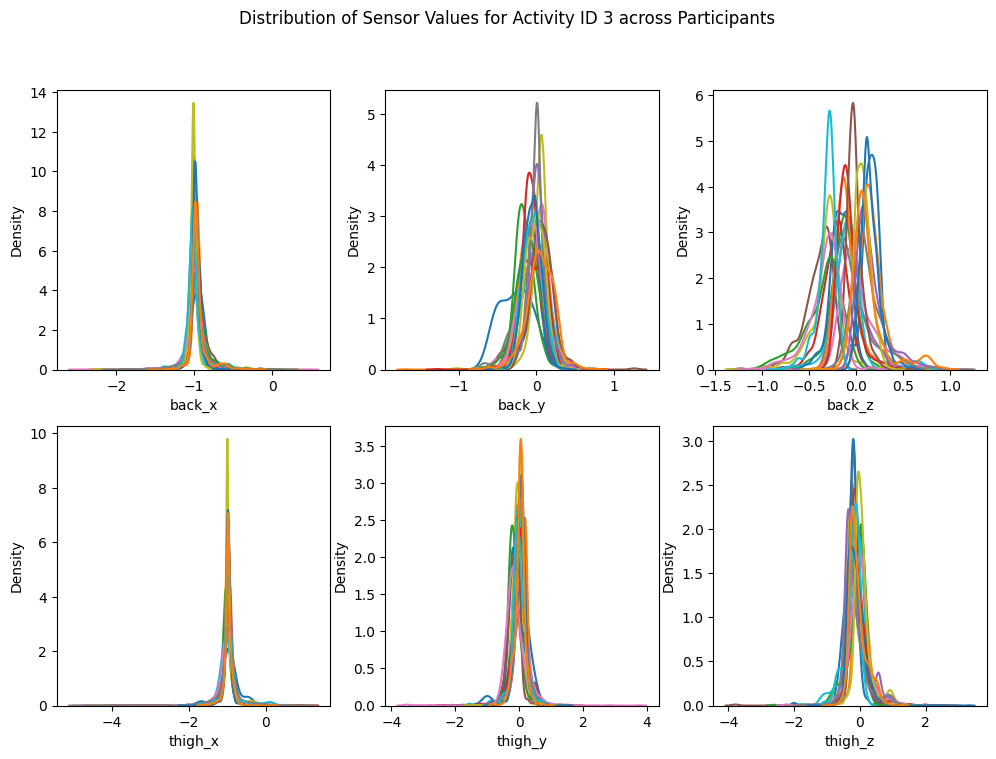

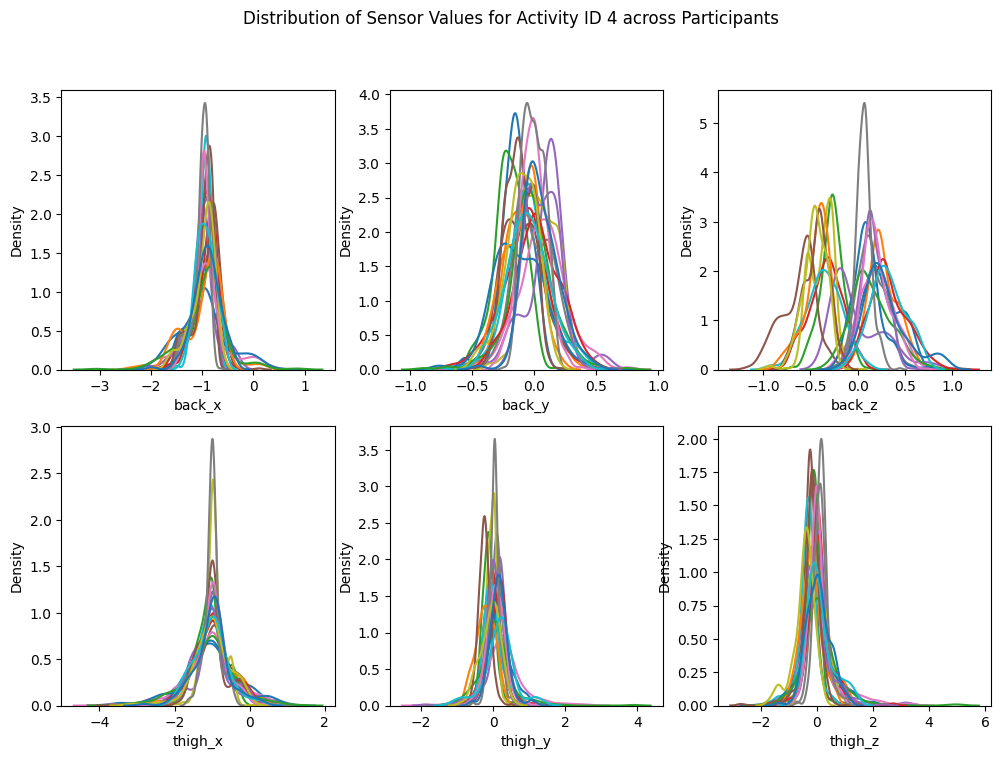

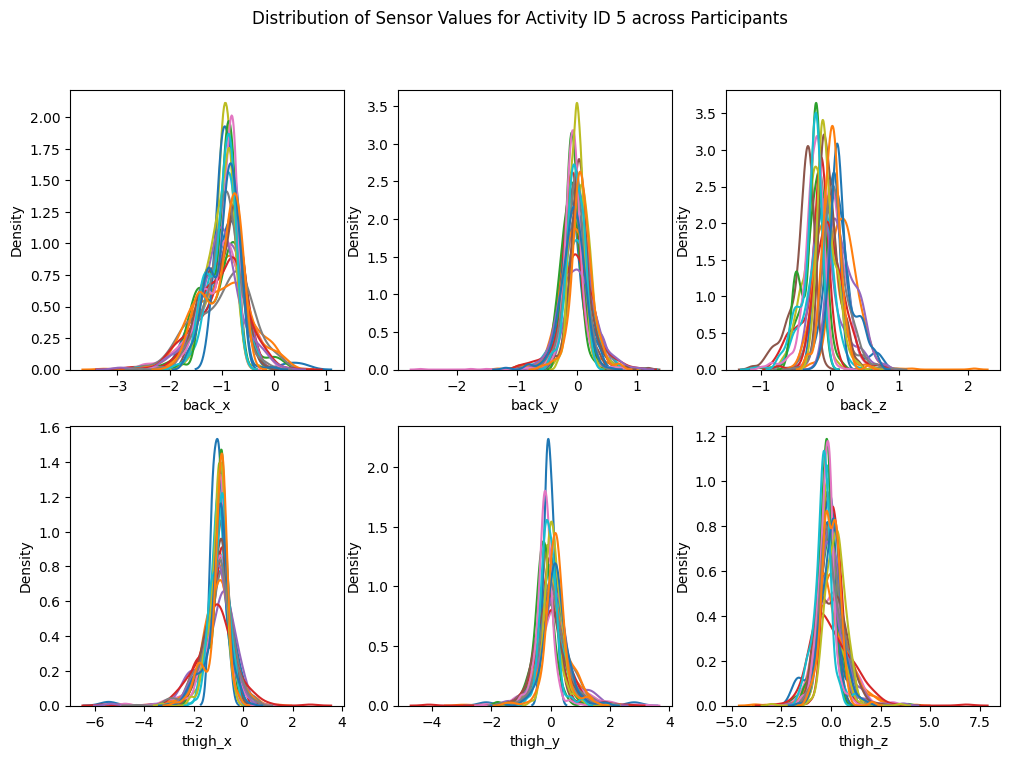

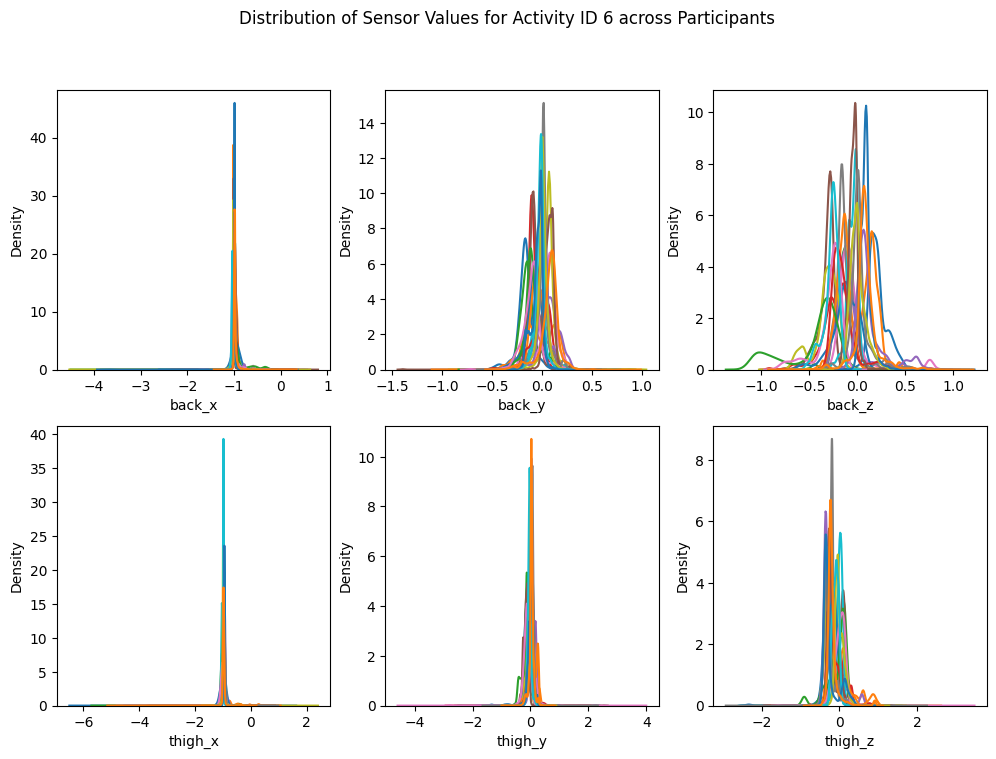

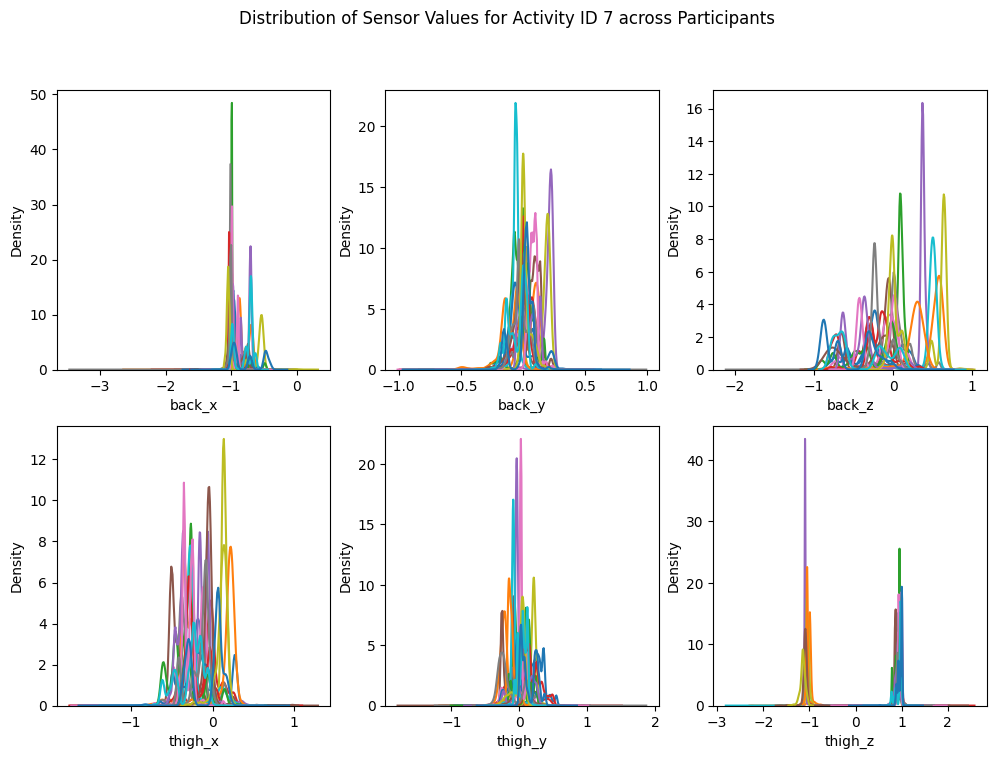

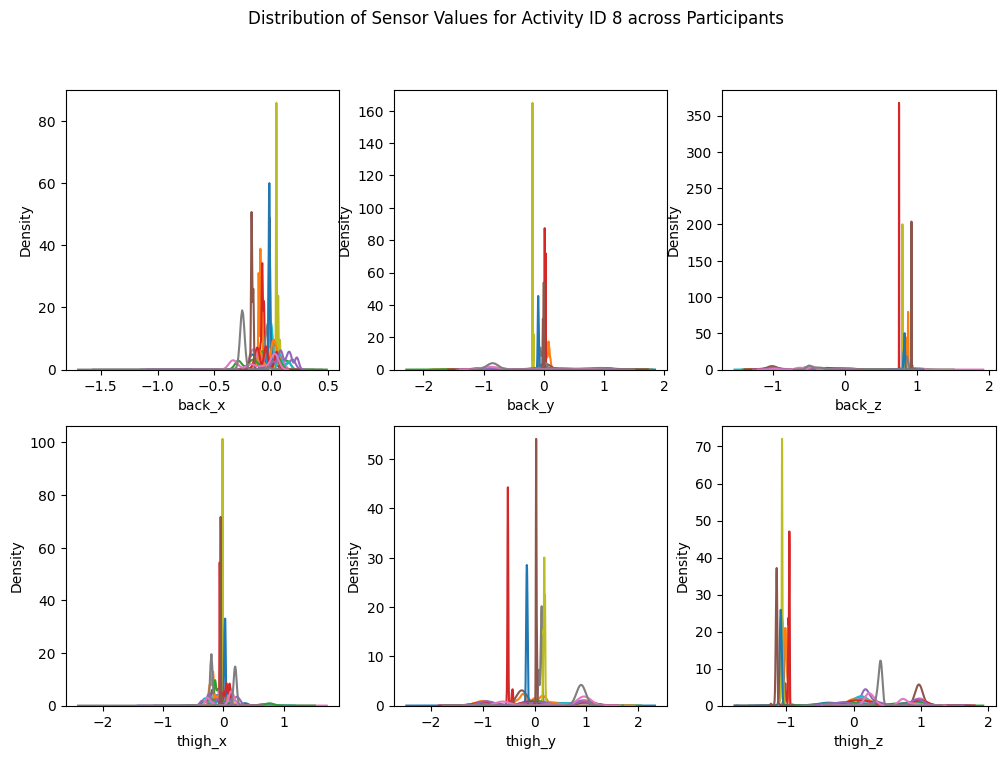

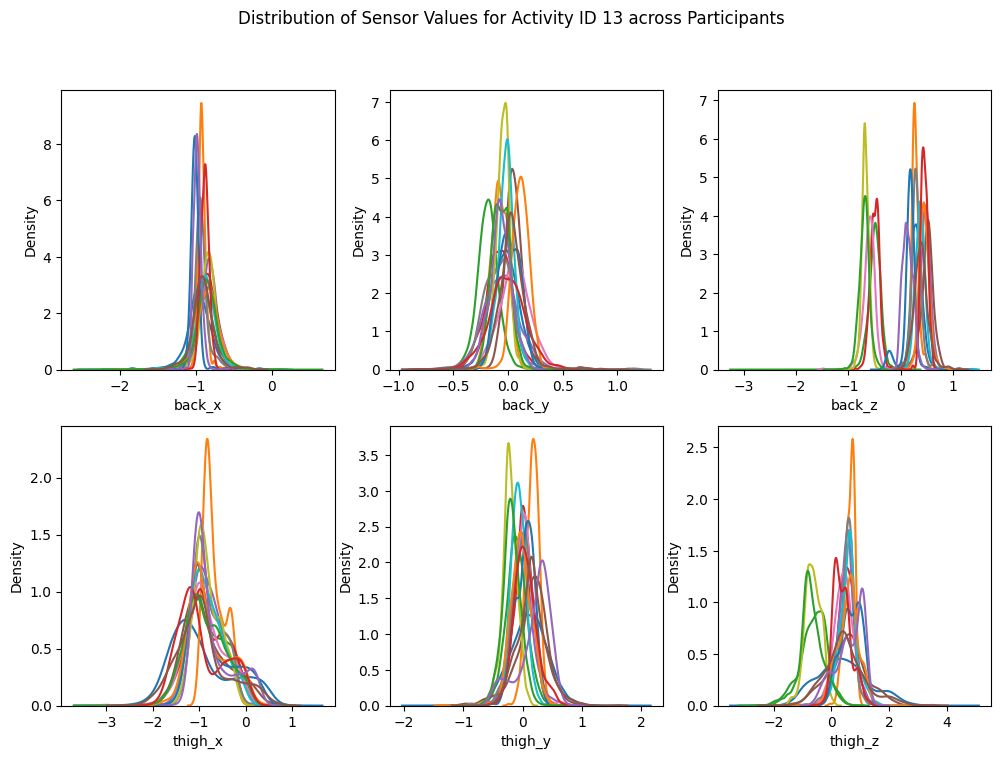

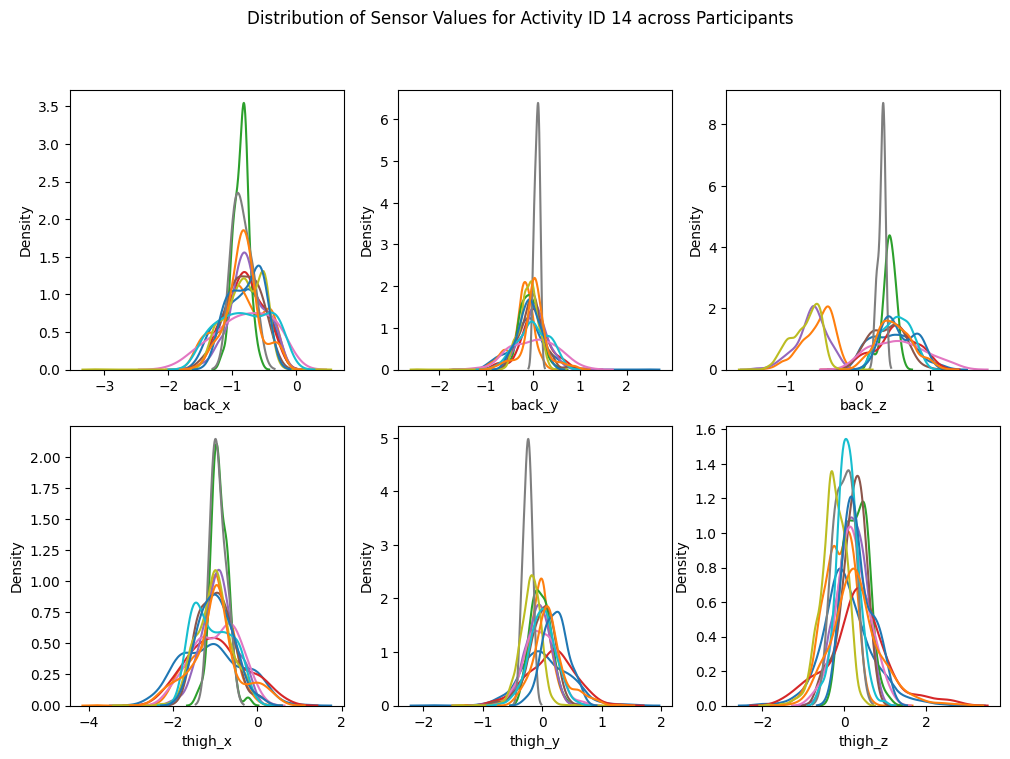

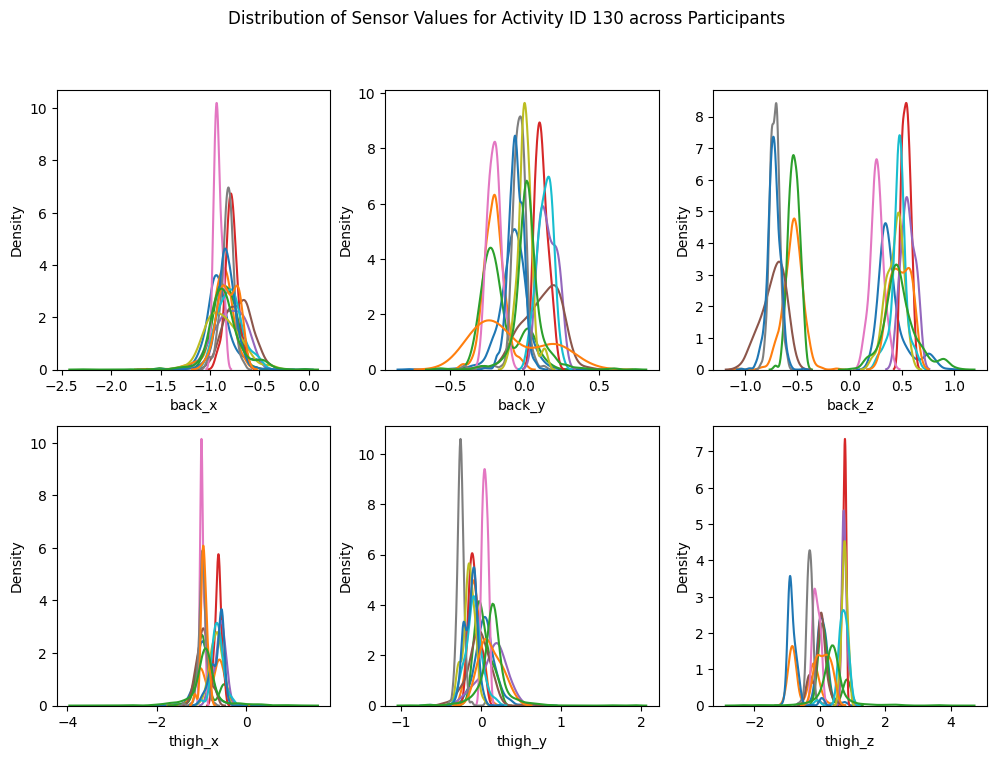

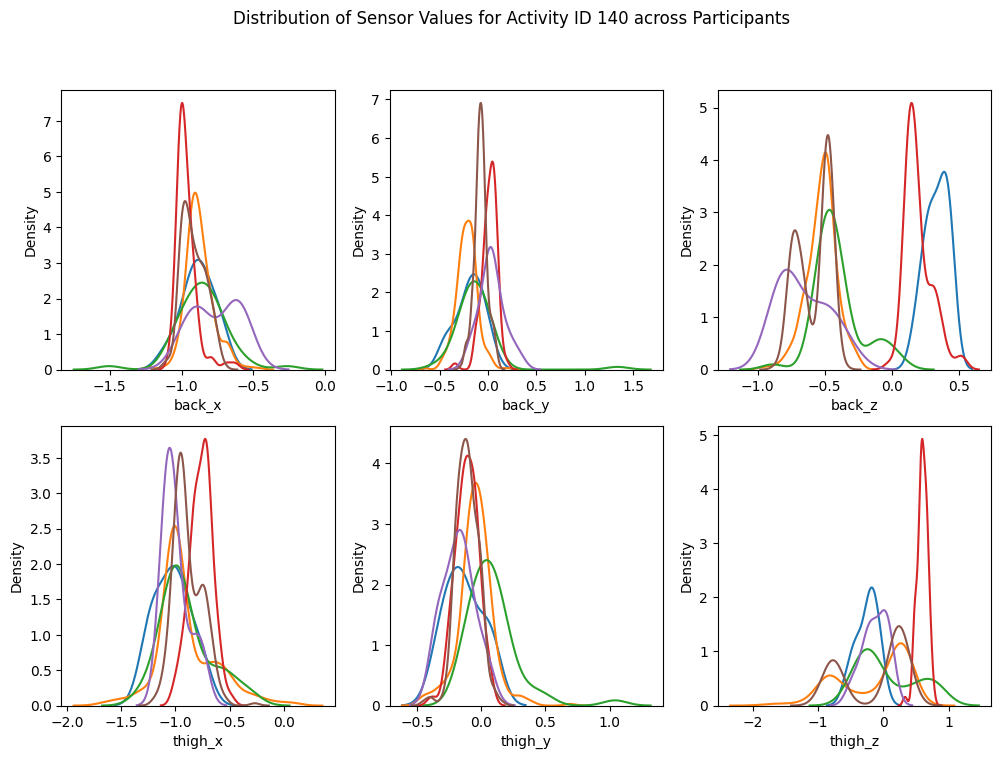

In [5]:
"""DISTRIBUTION OF SENSOR VALUES"""
# Plot histograms for each sensor value grouped by label across different participants
for label, groups in action_data_dict.items():
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Distribution of Sensor Values for Activity ID {label} across Participants')
    
    # Plot histograms for each sensor column
    for idx, sensor_col in enumerate(sensor_columns, 1):
        plt.subplot(2, 3, idx)
        
        # Plot data from different participants on the same graph
        # Loop through each action label
        for group in groups:
            # Plot PDF for sensor data of the current action label with KDE
            sns.kdeplot(group[sensor_col], fill=False)
    
    # Add a small pause to allow plots to display properly
    plt.pause(1.0)

In [9]:
# Step 1: Create a column to identify where the action changes
combined_data['action_change'] = (combined_data['label'] != combined_data['label'].shift(1)).cumsum()
print(combined_data[:300])

                     timestamp  back_x  back_y  back_z  thigh_x  thigh_y  \
0      2000-01-01 00:00:00.000 -0.9888 -0.1448  0.1833  -0.9919  -0.0227   
10000  2000-01-01 00:33:28.680 -1.0201  0.0495  0.3295  -1.3071  -0.3091   
4553   2000-01-01 00:17:54.000 -0.9832  0.0313 -0.2035  -0.3024   0.2560   
14553  2000-01-01 00:51:23.440 -0.9536  0.0157 -0.3045   0.2478   0.2490   
24553  2000-01-01 01:24:57.400 -0.9069 -0.3915  0.1163  -0.9331   0.3245   
...                        ...     ...     ...     ...      ...      ...   
30271  2019-01-12 01:44:03.680 -1.0035 -0.0250  0.1703  -1.1001   0.1367   
4729   2019-01-12 00:08:06.400 -0.9692  0.0318 -0.2541  -0.2774   0.2614   
14729  2019-01-12 00:25:01.810 -1.0894  0.1758  0.1716  -1.7288   0.0843   
24729  2019-01-12 00:42:10.370 -0.9960  0.0658 -0.0299   0.1942   0.1336   
34729  2019-01-12 00:59:09.020 -0.9923  0.1445  0.4513  -0.1728  -0.0706   

       thigh_z  label  file_id  Unnamed: 0  index  action_change  
0      -0.3065      

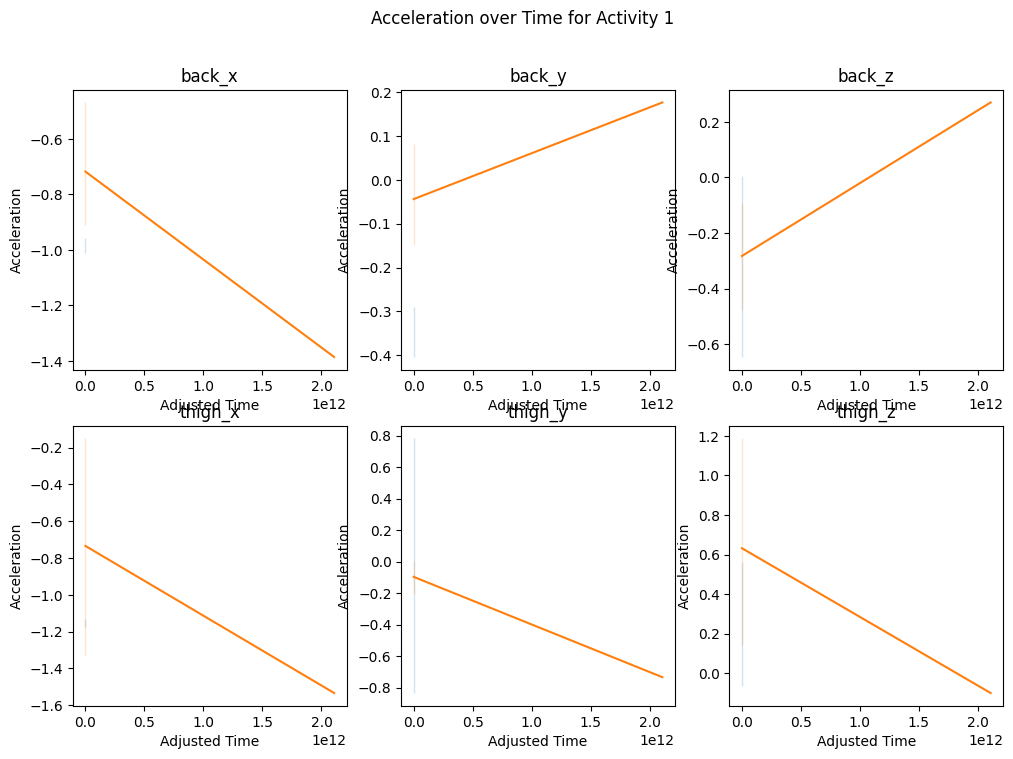

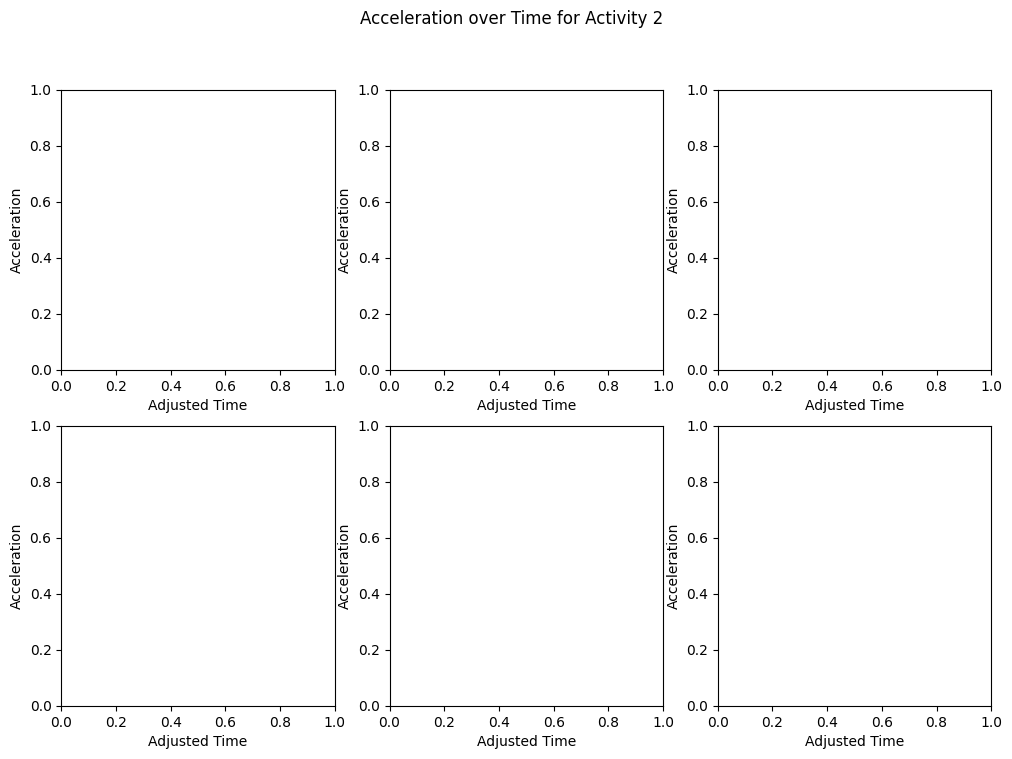

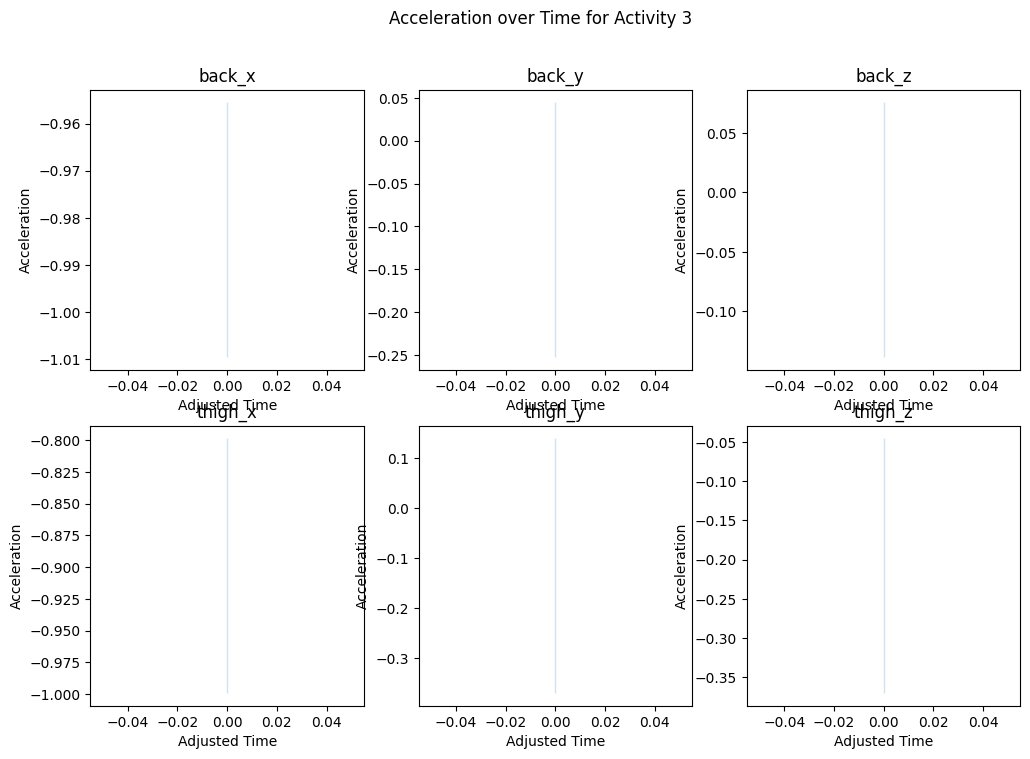

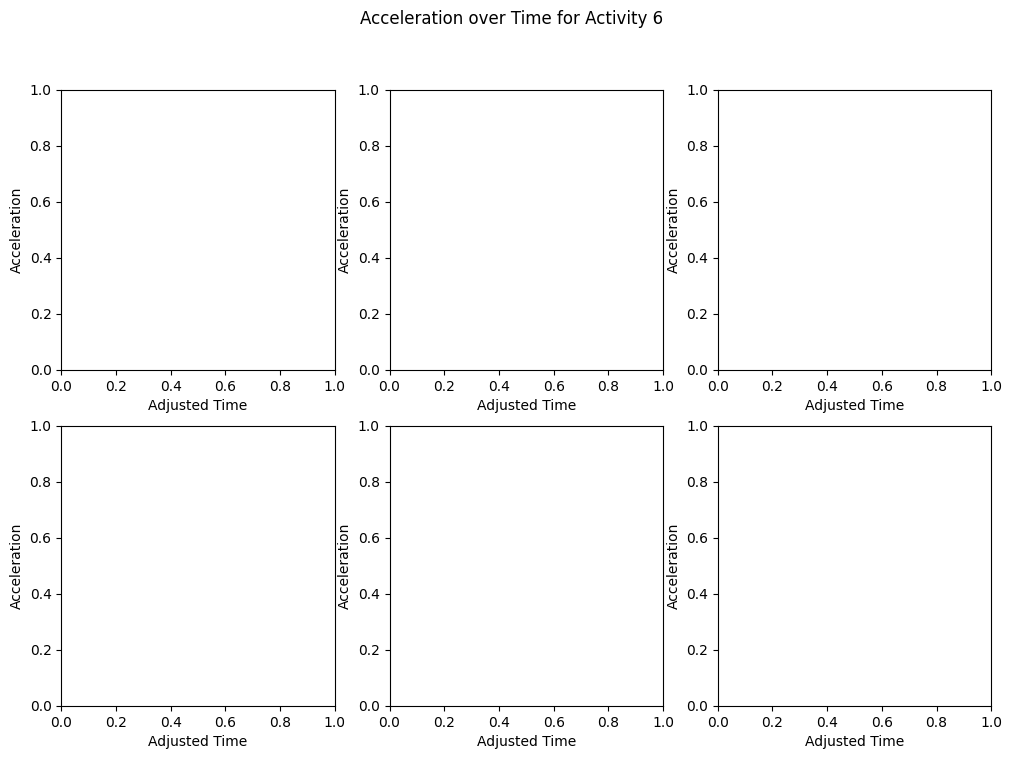

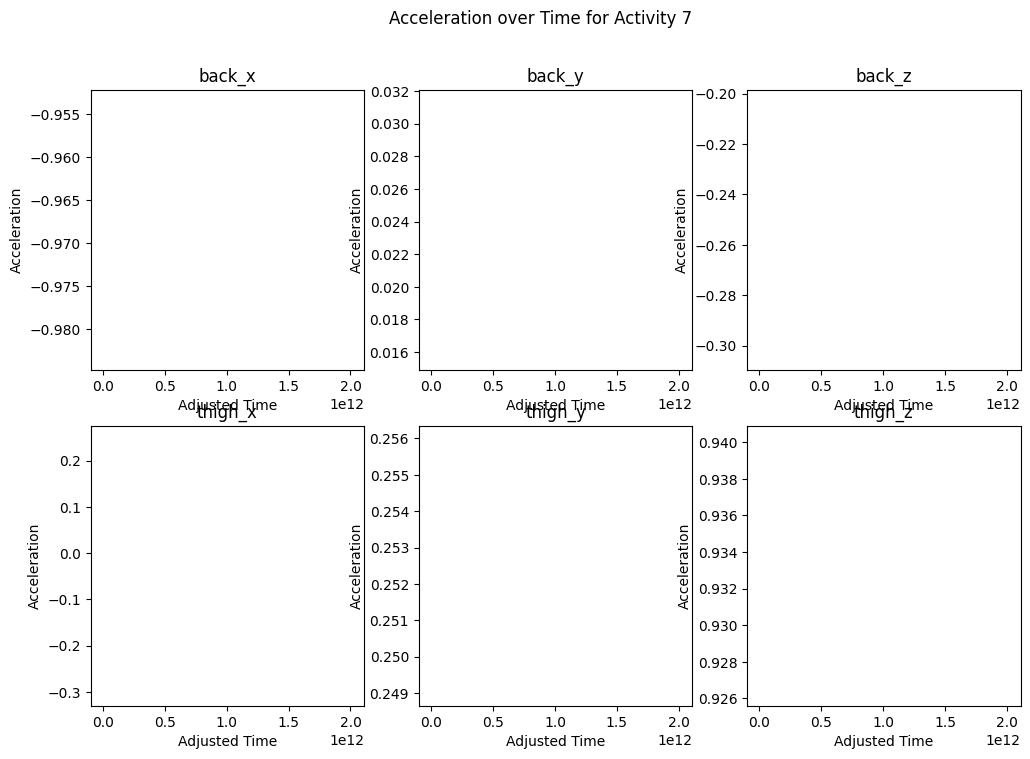

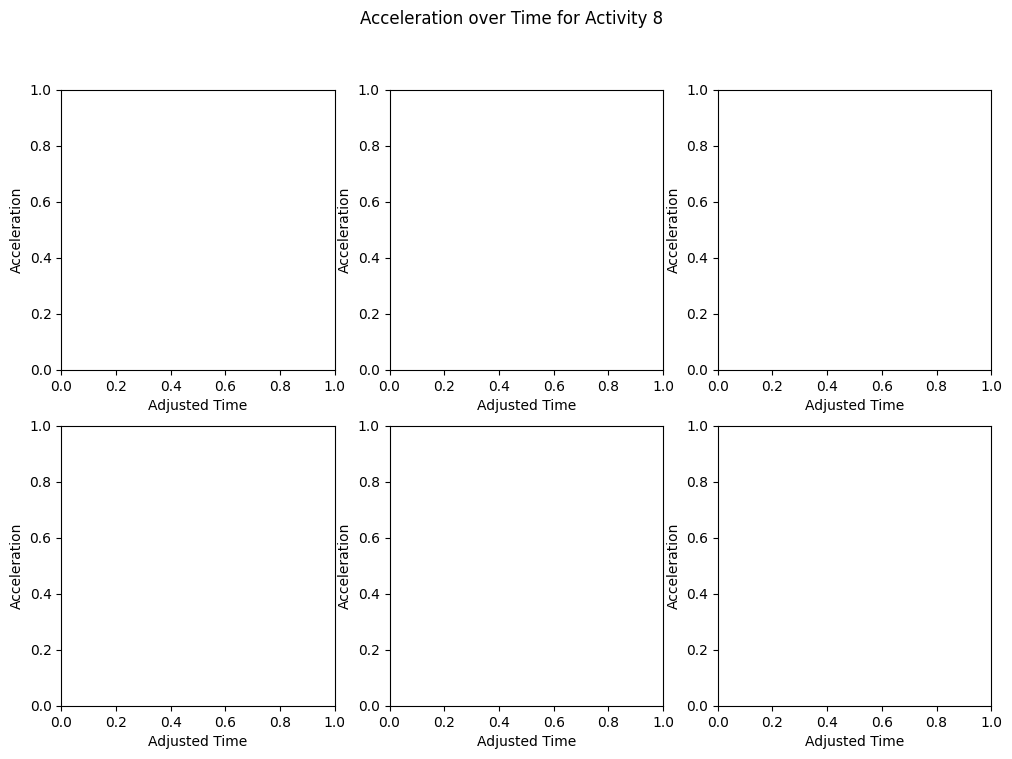

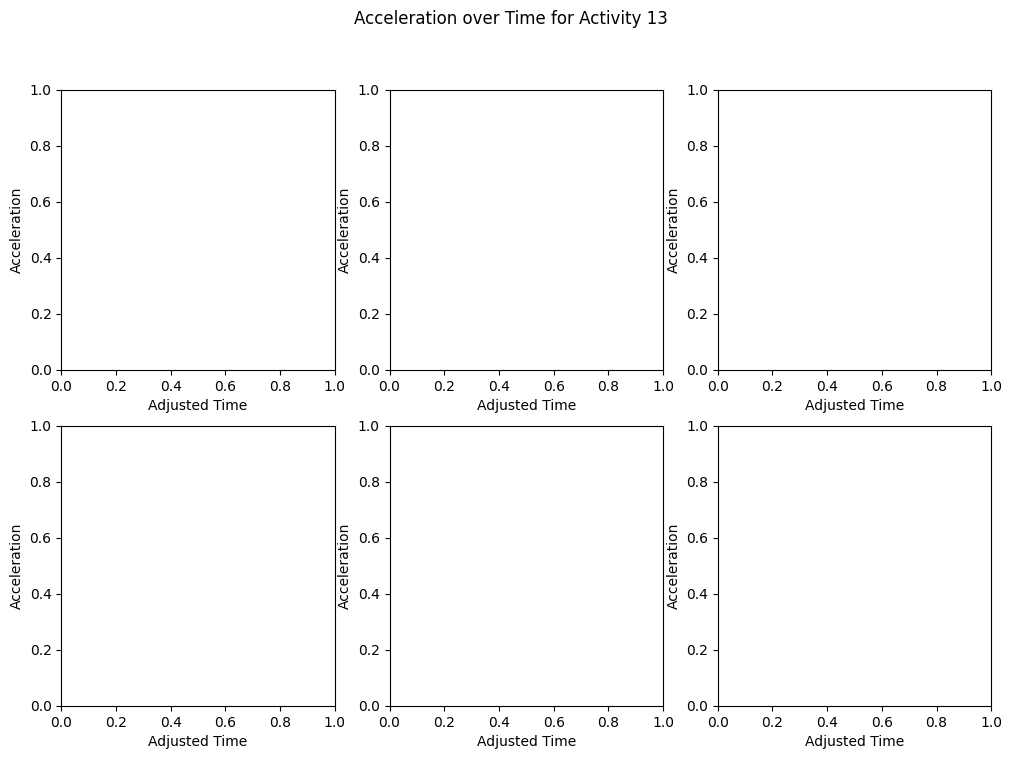

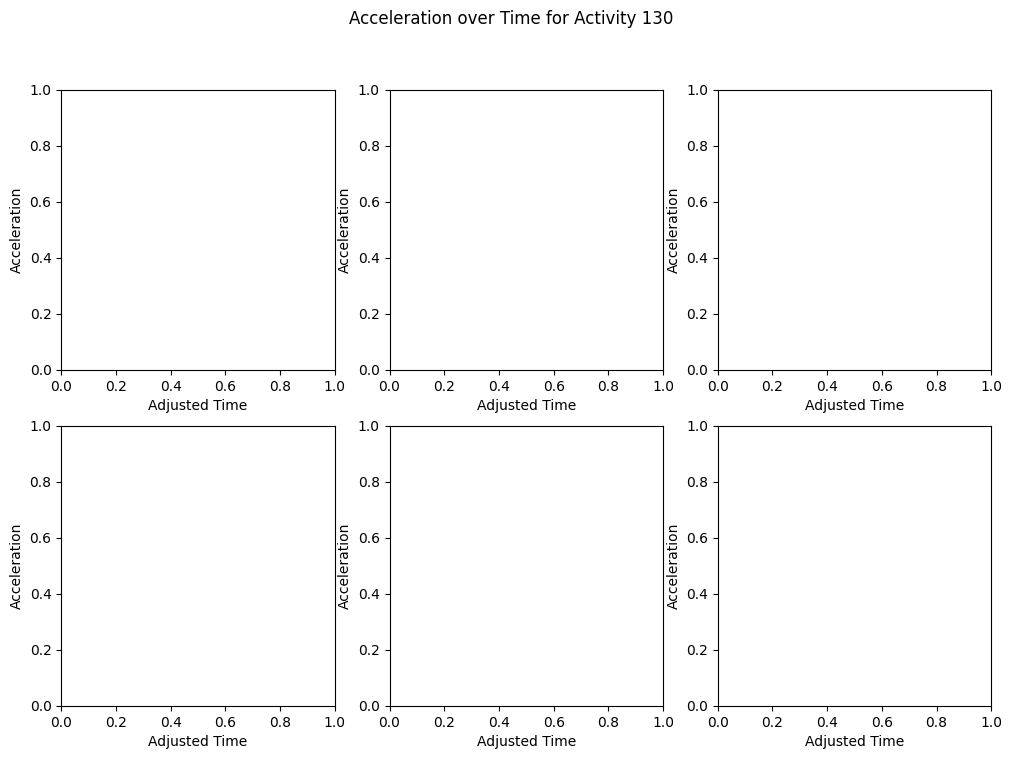

In [7]:
"""ACCELARATION OF ACTIONS IN TIME"""
combined_data=combined_data.iloc[::100]
grouped_data = combined_data.groupby('label')
time_threshold =  timedelta(seconds=2)  # 200 ms the time threshold

# Iterate through each group (activity label)
for label, group in grouped_data:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f'Acceleration over Time for Activity {label}')
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Initialize variables for the loop
    count=0
    file=0
    previous_timestamp = None
    time_difference = timedelta(seconds=0)
    time=[]
    accelaration_rows = {col: [] for col in sensor_columns}
    
    # Iterate through the rows in the group
    for idx, row in group.iterrows():
        if count==2:
            break
        # Convert current timestamp to datetime object
        current_timestamp = datetime.strptime(row['timestamp'], '%Y-%m-%d %H:%M:%S.%f')
        # Adjust the timestamp
        #firstly remove the date
        current_timestamp = (current_timestamp - current_timestamp.replace(hour=0, minute=0, second=0, microsecond=0))

        #initialize every beginning of an action to time zero
        if row["file_id"]!=file:
            time_difference=current_timestamp
            file=row['file_id']

        current_timestamp = current_timestamp - time_difference # subtracting the cumulative time difference

        # Calculate the time difference from the previous timestamp
        if previous_timestamp is not None:
            time_diff = current_timestamp - previous_timestamp

            # If time difference exceeds the threshold, reset time_difference
            if time_diff > time_threshold:
                time_difference += time_diff

                # Iterate through the sensor columns and plot each one in a different subplot
                for i, sensor_col in enumerate(sensor_columns):
                    sns.lineplot(x=time, 
                                y=accelaration_rows[sensor_col], 
                                ax=axes[i])
                    axes[i].set_title(sensor_col)
                
                # Reset the lists for the next segment
                time = []
                accelaration_rows = {col: [] for col in sensor_columns}
                count+=1

        #populate with the values of each segment
        time.append(current_timestamp)
        for col in sensor_columns:
            accelaration_rows[col].append(row[col])
        
        # Update the previous timestamp for the next iteration
        previous_timestamp = current_timestamp
    
    # Set common labels for the figure
    for ax in axes:
        ax.set_xlabel('Adjusted Time')
        ax.set_ylabel('Acceleration')